In [1]:
#!pip install firebase_admin pandas matplotlib seaborn scikit-learn

# Connessione a Firestore


In [2]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

device_id = "iliadbox-77F2A2"

cred = credentials.Certificate("baris-iot-vito-firebase-adminsdk-baww0-19695e55a0.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Estrazione Dati

In [3]:
prenotazioni_ref = db.collection('devices').document(device_id).collection('prenotazioni')
docs = prenotazioni_ref.stream()

data_list = []
for doc in docs:
    d = doc.to_dict()
    d['booking_id'] = doc.id
    data_list.append(d)

prenotazioni_df = pd.DataFrame(data_list)
prenotazioni_df.head()


,start_time,user_id,end_time,booking_id
0,2024-12-18T19:55:00.000,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-19T19:55:00.000,B89r3o17ppQUMpx7KiO2
1,2024-12-16T23:15:00.000,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-17T23:15:00.000,uZjKuwSLXBGkDGciWubU


## Convertiamo i campi data in tipo datetime

In [4]:
prenotazioni_df['start_time'] = pd.to_datetime(prenotazioni_df['start_time'])
prenotazioni_df['end_time'] = pd.to_datetime(prenotazioni_df['end_time'])

# Durata della prenotazione in ore
prenotazioni_df['duration_hours'] = (prenotazioni_df['end_time'] - prenotazioni_df['start_time']) / pd.Timedelta(hours=1)

prenotazioni_df.head()


,start_time,user_id,end_time,booking_id,duration_hours
0,2024-12-18 19:55:00,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-19 19:55:00,B89r3o17ppQUMpx7KiO2,24.0
1,2024-12-16 23:15:00,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-17 23:15:00,uZjKuwSLXBGkDGciWubU,24.0


# Lettura Access Log (Singolo Dispositivo)

In [5]:
access_logs_ref = db.collection('devices').document(device_id).collection('access_logs')
docs = access_logs_ref.stream()

logs_data = []
for doc in docs:
    d = doc.to_dict()
    d['log_id'] = doc.id
    # timestamp è una stringa, convertiamo a datetime
    d['timestamp'] = pd.to_datetime(d['timestamp'])
    logs_data.append(d)

logs_df = pd.DataFrame(logs_data)
logs_df.head()


,user_id,timestamp,action,log_id
0,None,2024-12-13 18:04:43.493207,chiusa,0eu4DsNaH5Hq042qVZvj
1,None,2024-12-16 14:13:28.525768,aperta,0pLgP1unilx3dqIumwTu
2,None,2024-12-17 16:26:39.408281,allarme_on,1CjnkIVuLptVdmlsFsgi
3,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-11 16:55:16.321752+00:00,unlock,1D1ZOCIhtY23Ohi6OkrS
4,None,2024-12-17 19:56:38.277441,allarme_off,1gikiQT9B4YqEanio690


# Lettura Access Log (Dispositivi Aggregati)

In [12]:
devices_ref = db.collection('devices')
devices_docs = devices_ref.stream()

all_logs = []
for device in devices_docs:
    device_id = device.id
    access_logs_ref = db.collection('devices').document(device_id).collection('access_logs')
    logs = access_logs_ref.stream()

    for doc in logs:
        d = doc.to_dict()
        d['log_id'] = doc.id
        d['device_id'] = device_id  # aggiungi info sul device
        # timestamp è una stringa, convertiamo a datetime
        d['timestamp'] = pd.to_datetime(d['timestamp'])
        all_logs.append(d)

logs_df = pd.DataFrame(all_logs)
logs_df.head()

,user_id,timestamp,action,log_id,device_id
0,None,2024-12-13 18:04:43.493207,chiusa,0eu4DsNaH5Hq042qVZvj,iliadbox-77F2A2
1,None,2024-12-16 14:13:28.525768,aperta,0pLgP1unilx3dqIumwTu,iliadbox-77F2A2
2,None,2024-12-17 16:26:39.408281,allarme_on,1CjnkIVuLptVdmlsFsgi,iliadbox-77F2A2
3,rYRiHUTLmVWAthnuaBXrx0dlHT02,2024-12-11 16:55:16.321752+00:00,unlock,1D1ZOCIhtY23Ohi6OkrS,iliadbox-77F2A2
4,None,2024-12-17 19:56:38.277441,allarme_off,1gikiQT9B4YqEanio690,iliadbox-77F2A2


# Analisi Esplorativa

## Prenotazioni per giorno

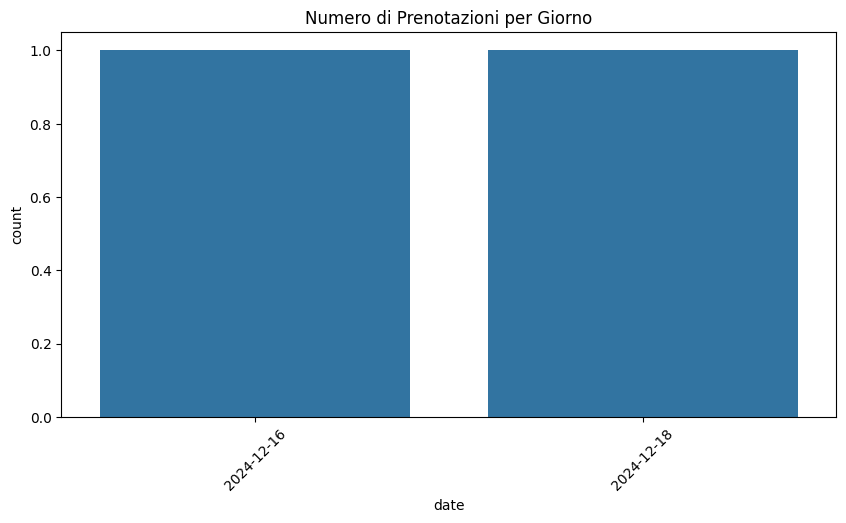

In [6]:
prenotazioni_df['date'] = prenotazioni_df['start_time'].dt.date
daily_bookings = prenotazioni_df.groupby('date')['booking_id'].count().reset_index()
daily_bookings.columns = ['date', 'count']
daily_bookings.head()

plt.figure(figsize=(10,5))
sns.barplot(x='date', y='count', data=daily_bookings)
plt.xticks(rotation=45)
plt.title("Numero di Prenotazioni per Giorno")
plt.show()


## Durata media prenotazioni

In [7]:
mean_duration = prenotazioni_df['duration_hours'].mean()
print(f"Durata media delle prenotazioni: {mean_duration:.2f} ore")


Durata media delle prenotazioni: 24.00 ore


## Analisi dei log per vedere il numero di volte che la porta è stata aperta

In [8]:
porta_aperta_count = (logs_df['action'] == 'porta aperta').sum()
print("Numero di volte che la porta è stata aperta:", porta_aperta_count)

Numero di volte che la porta è stata aperta: 11


## Grafico degli orari più frequenti di apertura porta:

In [11]:
type(logs_df['timestamp'])


pandas.core.series.Series

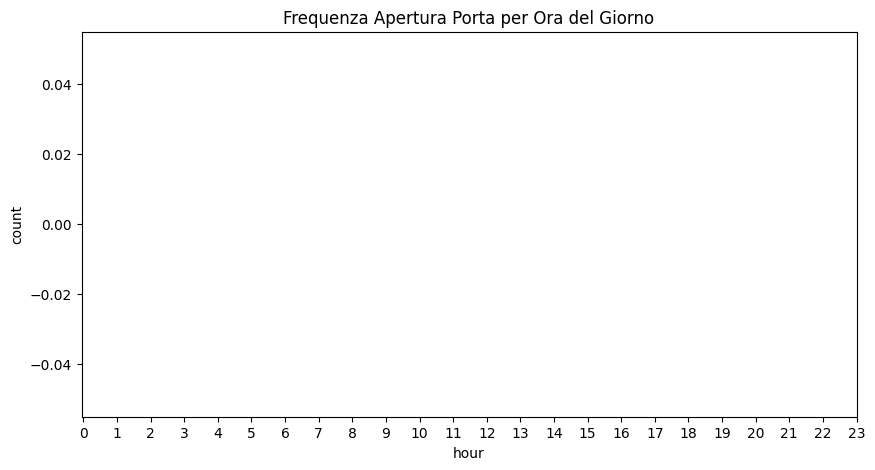

In [16]:
logs_df['hour'] = logs_df['timestamp'].dt.hour
porta_aperta_df = logs_df[logs_df['action'] == 'porta aperta']
hourly = porta_aperta_df.groupby('hour').size().reset_index(name='count')

plt.figure(figsize=(10,5))
sns.lineplot(x='hour', y='count', data=hourly, marker='o')
plt.title("Frequenza Apertura Porta per Ora del Giorno")
plt.xticks(range(0,24))
plt.show()


# Uso di ML
### clusterizzare i giorni in base al numero di prenotazioni, aperture porta, effrazioni.

## Creiamo un DataFrame aggregato giornalmente

In [9]:
logs_df['date'] = logs_df['timestamp'].dt.date
daily_stats = logs_df.groupby('date')['action'].value_counts().unstack(fill_value=0)
daily_stats.head()


AttributeError: Can only use .dt accessor with datetimelike values

## Normalizza i dati e usa KMeans per clusterizzare i giorni

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(daily_stats)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

daily_stats['cluster'] = clusters
daily_stats.head()

# Osserva le medie per cluster
print(daily_stats.groupby('cluster').mean())
